In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
param_grid = {"C": [10**k for k in range(-10, 6, 2)]}  
scoring = "roc_auc"; cv = 3; random_state=42
random.seed(random_state)

In [3]:
with open("genre_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    genre_map = json.load(f)
aligned_genre = list(genre_map)[:-1]

with open("instrument_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    instrument_map = json.load(f)

# Load embeddings and align classes

In [5]:
embedding = 'vggish'
debias_method = ''

# load embeddings
embeddings = h5py.File("embeddings.h5", "r")

In [6]:
embedding = "vggish"
debias_method = ""

###### IRMAS data ######
feature = np.array(embeddings["irmas"][embedding]["features"])
keys_ori = np.array(embeddings["irmas"][embedding]["keys"])
key_clip = np.unique(keys_ori)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 128) (6705,)


In [7]:
def load_feature(meta, feature_clip, key_clip):
    key_train = list(meta.loc[(meta['split'] == 'train')]['file_name'])
    key_test = list(meta.loc[(meta['split'] == 'test')]['file_name'])

    idx_train = [list(key_clip).index(item) for item in key_train]
    idx_test = [list(key_clip).index(item) for item in key_test]
   
    # cast the idx_* arrays to numpy structures
    idx_train = np.asarray(idx_train)
    idx_test = np.asarray(idx_test)

    # use the split indices to partition the features, labels, and masks
    X_train = feature_clip[idx_train,:]
    X_test = feature_clip[idx_test]

    Y_train = meta.loc[(meta['split'] == 'train')]['instrument'].values
    Y_test = meta.loc[(meta['split'] == 'test')]['instrument'].values

    genre_train = meta.loc[(meta['split'] == 'train')]['genre'].values
    genre_test = meta.loc[(meta['split'] == 'test')]['genre'].values

    return (X_train, Y_train), (X_test, Y_test), (genre_train, genre_test)

In [8]:
A_meta = pd.read_csv("A_meta.csv")
(X_train_A, Y_train_A), (X_test_A, Y_test_A), (genre_train_A, genre_test_A) = load_feature(A_meta, feature_clip, key_clip)
B_meta = pd.read_csv("B_meta.csv")
(X_train_B, Y_train_B), (X_test_B, Y_test_B), (genre_train_B, genre_test_B) = load_feature(B_meta, feature_clip, key_clip)

# data composition

In [9]:
# check data amount
A_inst = []
A_noninst = []
A_inst_genre = {inst:[] for inst in instrument_map}
B_inst = []
B_noninst = []
B_inst_genre = {inst:[] for inst in instrument_map}

for inst in instrument_map:
    Y_train_A_inst = Y_train_A==inst
    Y_train_B_inst = Y_train_B==inst

    Y_train_A_noninst = Y_train_A!=inst
    Y_train_B_noninst = Y_train_B!=inst

    X_train_A_inst = X_train_A[Y_train_A_inst]
    X_train_B_inst = X_train_B[Y_train_B_inst]

    X_train_A_noninst = X_train_A[Y_train_A_noninst]
    X_train_B_noninst = X_train_B[Y_train_B_noninst]

    genre_train_A_inst = genre_train_A[Y_train_A_inst]
    genre_train_B_inst = genre_train_B[Y_train_B_inst]

    A_inst.append(X_train_A_inst.shape[0])
    A_noninst.append(X_train_A_noninst.shape[0])
    B_inst.append(X_train_B_inst.shape[0])
    B_noninst.append(X_train_B_noninst.shape[0])

    A_inst_genre[inst] = genre_train_A_inst
    B_inst_genre[inst] = genre_train_B_inst

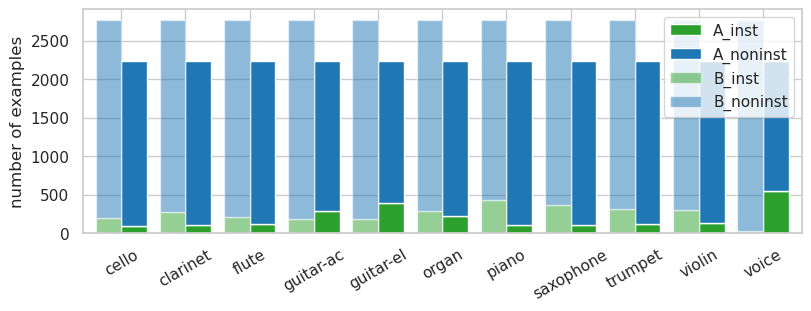

In [10]:
sns.set_theme(context='notebook', style='whitegrid')
plt.rcParams['figure.constrained_layout.use'] = True
df = pd.DataFrame({'instrument': list(instrument_map), 
                    'A_inst': A_inst,
                    'A_noninst': A_noninst,
                    'B_inst': B_inst,
                    'B_noninst': B_noninst})

fig, ax = plt.subplots(figsize=(8,3))
# colors = ['#0271AE', '#DC2830']
colors = ['tab:green', 'tab:blue']
# colors = ['green', 'blue', 'tab:green', 'tab:blue']
df.plot(stacked=True, kind='bar', x='instrument', y=['A_inst','A_noninst'], ax=ax, position=0, width=0.4, color=colors)
df.plot(stacked=True, kind='bar', x='instrument', y=['B_inst','B_noninst'], ax=ax, position=1, width=0.4, color=colors, alpha=.5)
plt.xlim([-.6, len(df) - .4])
plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('number of examples')
plt.savefig('results/train_set_distribution.pdf', bbox_inches='tight')

In [11]:
with open("genre_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    genre_map = json.load(f)

In [12]:
genre_info = pd.DataFrame(columns=['instrument', 'genre', 'examples', 'train_set'])

for inst in instrument_map:
    inst_genre_num = []
    for genre in list(genre_map):
        inst_genre_num.append(len(A_inst_genre[inst][A_inst_genre[inst] == genre]))

    genre_inst = pd.DataFrame(columns=['instrument', 'genre', 'examples', 'train_set'])
    genre_inst['instrument'] = [inst] * len(list(genre_map))
    genre_inst['genre'] = list(genre_map)
    genre_inst['examples'] = inst_genre_num
    genre_inst['train_set'] = ['A'] * len(list(genre_map))

    genre_info = genre_info.append(genre_inst)
    
for inst in instrument_map:
    inst_genre_num = []
    for genre in list(genre_map):
        inst_genre_num.append(len(B_inst_genre[inst][B_inst_genre[inst] == genre]))

    genre_inst = pd.DataFrame(columns=['instrument', 'genre', 'examples', 'train_set'])
    genre_inst['instrument'] = [inst] * len(list(genre_map))
    genre_inst['genre'] = list(genre_map)
    genre_inst['examples'] = inst_genre_num
    genre_inst['train_set'] = ['B'] * len(list(genre_map))

    genre_info = genre_info.append(genre_inst)

In [13]:
genre_info[:10]

,instrument,genre,examples,train_set
0,cello,classical,0,A
1,cello,country_folk,0,A
2,cello,jazz_blue,0,A
3,cello,latin_soul,0,A
4,cello,pop_roc,88,A
0,clarinet,classical,0,A
1,clarinet,country_folk,0,A
2,clarinet,jazz_blue,0,A
3,clarinet,latin_soul,0,A
4,clarinet,pop_roc,104,A


In [14]:
A_perinst = []
for instrument in instrument_map:
    A_perinst.append(list(genre_info.loc[(genre_info['train_set'] == 'A') & (genre_info['instrument'] == instrument)]['examples']))

A_perinst = np.array(A_perinst)
np.transpose(A_perinst)[:-1,:].sum(0)

array([  0,   0,  24,  57,  47,   2,   8,   2,   0,  26, 224])

In [15]:
B_perinst = []
for instrument in instrument_map:
    B_perinst.append(list(genre_info.loc[(genre_info['train_set'] == 'B') & (genre_info['instrument'] == instrument)]['examples']))

B_perinst = np.array(B_perinst)
np.transpose(B_perinst)[:-1,:].sum(0)

array([202, 274, 210, 184, 181, 290, 426, 365, 311, 298,  29])

In [16]:
A_inst = []; B_inst = []
for inst in instrument_map:
    A_inst.append(genre_info.loc[(genre_info['instrument'] == inst) & (genre_info['train_set'] == 'A')]['examples'].sum())
    B_inst.append(genre_info.loc[(genre_info['instrument'] == inst) & (genre_info['train_set'] == 'B')]['examples'].sum())
print(instrument_map)
print(A_inst)
print(B_inst)

{'cello': '0', 'clarinet': '1', 'flute': '2', 'guitar-ac': '3', 'guitar-el': '4', 'organ': '5', 'piano': '6', 'saxophone': '7', 'trumpet': '8', 'violin': '9', 'voice': '10'}
[88, 104, 126, 292, 387, 221, 113, 103, 120, 135, 553]
[202, 274, 210, 184, 181, 290, 426, 365, 311, 298, 29]


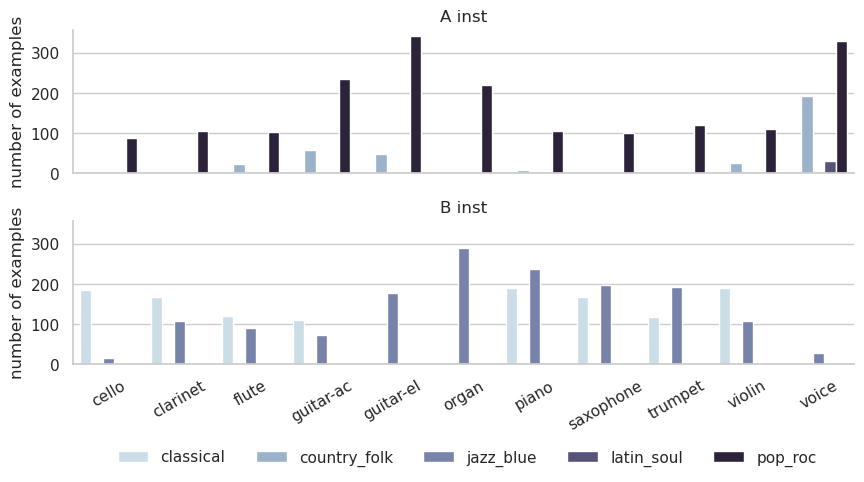

In [17]:
# save cosine similarity into a csv file
sns.set_theme(context='notebook', style='whitegrid') # , font_scale=1.6)

ax = sns.catplot(data=genre_info, row='train_set', x='instrument', y='examples', hue='genre', kind='bar', height=2.2, aspect=4,
               legend_out=False, palette="ch:s=.25,rot=-.25")

a0 = ax.fig.axes[0]
a0.set_title("A inst")
# a0.set_ylim([0,400])
a1 = ax.fig.axes[1]
a1.set_title("B inst")
# a1.set_ylim([0,400])

ax.set(ylabel='number of examples')
ax.set(xlabel=None)
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.11), ncol=6, title=None, frameon=False)
plt.subplots_adjust(wspace=0.1)
ax.set_xticklabels(rotation=30)
# plt.title('Genre information per instrument')
# plt.savefig('results/genre_information.pdf', bbox_inches='tight')